In [1]:
import h5py
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from numpy.random import seed
import random
import os
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix


1. Mount google drive

2. Load the data files

3. Visualize the loaded data (some of randomly selected images from data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


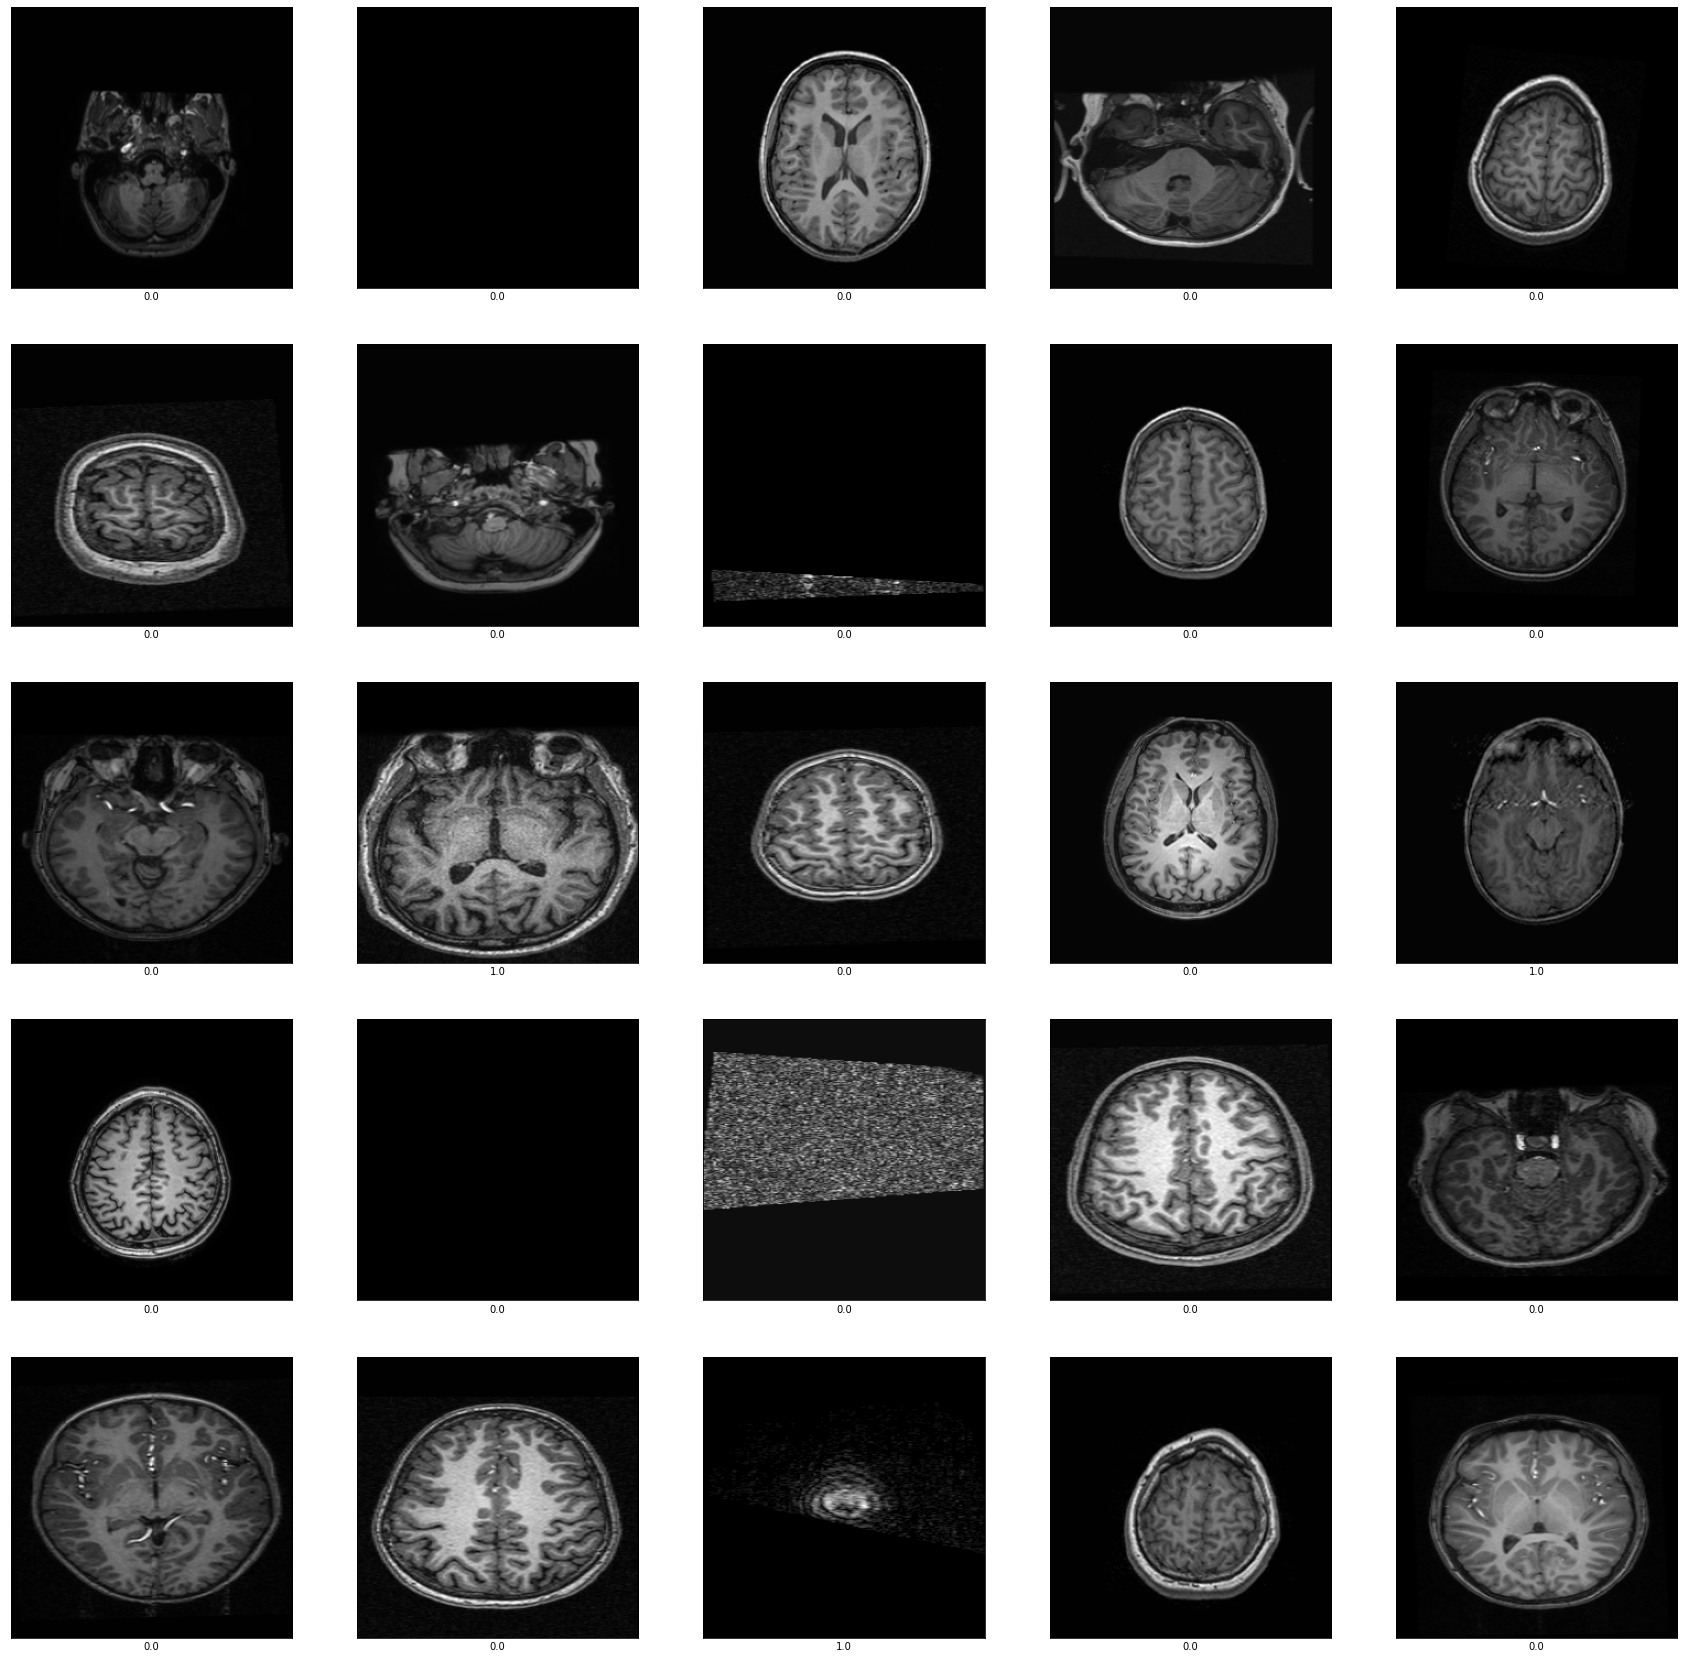

In [9]:
# mount drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')


# load data for Coronal Plane
data=h5py.File('/content/drive/MyDrive/abide/AbideTrainV1.h5','r')
train_images=data.get("image")
train_labels=data.get("label")
#validation data
data=h5py.File('/content/drive/MyDrive/abide/AbideValidV1.h5','r')
test_images=data.get("image")
test_labels=data.get("label")
# test data
data=h5py.File('/content/drive/MyDrive/abide/AbideTestV1.h5','r')
test_images2=data.get("image")
test_labels2=data.get("label")


## Visualaize the data
# verify data
ids=np.random.randint(len(train_images), size=(25))
plt.figure(figsize=(30,30))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im=train_images[ids[i]]
    plt.imshow(im,cmap='gray')
    plt.xlabel(train_labels[ids[i]])
plt.show()


# Convert data in usable form for network
train_images= np.asarray(train_images)
train_labels= np.asarray(train_labels)
test_images= np.asarray(test_images)
test_labels= np.asarray(test_labels)
test_images2= np.asarray(test_images2)
test_labels2= np.asarray(test_labels2)


train_images=np.expand_dims(train_images,axis=3)


How can we reproduce the results ? Tried the following but didnt work

In [4]:
seedvalue=1

seed(seedvalue)
tf.compat.v1.set_random_seed(seedvalue)
tf.random.set_seed(seedvalue)
random.seed(seedvalue)
tf.keras.utils.set_random_seed(
    seedvalue
)
os.environ['PYTHONHASHSEED'] = '0'
os.environ["TF_DETERMINISTIC_OPS"] = str(seedvalue)


Define DCNN network 

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(4, (3, 3), activation='relu'))


layer = tf.keras.layers.Dropout(.2)
#model.add(layer)
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
layer2 = tf.keras.layers.Dropout(.6)
#model.add(layer2)
model.add(layers.Dense(1,activation='sigmoid'))



model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 16)      

Define datagenrator for image augmentation.

In [11]:
train_datagen = ImageDataGenerator(zoom_range=0.2,  
                                   rotation_range=10,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True,
                                   #brightness_range = [0.8, 1.2],
                                   #fill_mode='nearest',        
                                   #validation_split=0.2
                                   )
train_datagen.fit(train_images)
train_images.shape

(21120, 256, 256, 1)

In [ ]:
'''# display augmented images
a=(train_datagen.flow(train_images, train_labels, batch_size=len(train_images),shuffle=False)) # a is a tuple with a[i][j], i is the batch number, j=0 are images, j=1 are labels
plt.figure(figsize=(30,30))
for i in range(2):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im=a[0][0][ids[i]]
    im=np.squeeze(im,axis=2)
    plt.imshow(im,cmap='gray')
    plt.xlabel(a[0][1][ids[i]])
plt.show()
'''

"# display augmented images\na=(train_datagen.flow(train_images, train_labels, batch_size=len(train_images),shuffle=False)) # a is a tuple with a[i][j], i is the batch number, j=0 are images, j=1 are labels\nplt.figure(figsize=(30,30))\nfor i in range(2):\n    plt.subplot(5,5,i+1)\n    plt.xticks([])\n    plt.yticks([])\n    plt.grid(False)\n    im=a[0][0][ids[i]]\n    im=np.squeeze(im,axis=2)\n    plt.imshow(im,cmap='gray')\n    plt.xlabel(a[0][1][ids[i]])\nplt.show()\n"

In [ ]:
#del a # free ram

1. Define 
  optimizer, 
  loss function
  class weights

2. Compile DCNN Model
3. Train DCNN model with imagedatagenerator for training. (test images are not augmented and not shuffled ofcourse)

In [12]:

opt = keras.optimizers.Adam(learning_rate=0.001,    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)
los= tf.keras.losses.BinaryCrossentropy(from_logits=False)

weights={0: 0.57,
         1: 4.03}

print(sum(train_labels))

####

model.compile(optimizer=opt,
              loss=los,
              metrics=['accuracy','TruePositives','AUC'])

mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath='modelbest.h5', save_best_only=True, monitor='val_accuracy', mode='max')

#####

history=model.fit_generator(train_datagen.flow(train_images, train_labels, batch_size=64),
         validation_data=(test_images, test_labels) ,
         steps_per_epoch=len(train_images) / 64, epochs=300,class_weight=weights,callbacks=[mcp_save])

model.save('AxialAbideCnn300epochsOnce.h5')

2560.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/300
330/330 [==============================] - 120s 360ms/step - loss: 0.6732 - accuracy: 0.5338 - true_positives: 1680.0000 - auc: 0.6114 - val_loss: 0.7304 - val_accuracy: 0.5125 - val_true_positives: 611.0000 - val_auc: 0.6133
Epoch 2/300
330/330 [==============================] - 114s 347ms/step - loss: 0.6355 - accuracy: 0.5573 - true_positives: 1880.0000 - auc: 0.6677 - val_loss: 0.6371 - val_accuracy: 0.5503 - val_true_positives: 585.0000 - val_auc: 0.6325
Epoch 3/300
330/330 [==============================] - 115s 347ms/step - loss: 0.6097 - accuracy: 0.5549 - true_positives: 2027.0000 - auc: 0.6984 - val_loss: 0.7070 - val_accuracy: 0.4568 - val_true_positives: 738.0000 - val_auc: 0.6662
Epoch 4/300
330/330 [==============================] - 115s 347ms/step - loss: 0.5986 - accuracy: 0.5540 - true_positives: 2090.0000 - auc: 0.7127 - val_loss: 0.5773 - val_accuracy: 0.5491 - val_true_positives: 656.0000 - val_auc: 0.6852
Epoch 5/300
330/330 [===========================

Accuracy, Loss and AUC plots for learned DCNN model

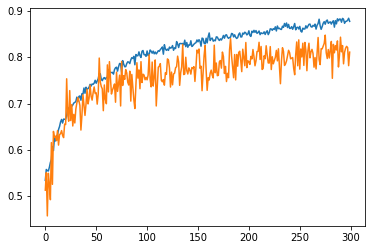

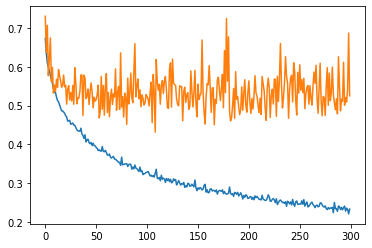

In [14]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')


Compute eperformance metrics for validation and test data prediction

In [39]:
# for validation data (test_images)
prediction = model.predict(test_images)
matrix = confusion_matrix(test_labels, np.round(prediction))
print(matrix)

[[5174 1002]
 [ 327  537]]


In [40]:
# for test data (test_images2)
prediction = model.predict(test_images2)
matrix = confusion_matrix(test_labels2, np.round(prediction))
print(matrix)

[[5175 1033]
 [ 329  535]]


In [38]:
# load saved trained 2dcnn model
model = keras.models.load_model("AxialAbideCnn300epochsOnce.h5")



FC Module

In [19]:
from tensorflow import keras

# Instantiate an optimizer.
optimizer = opt = keras.optimizers.Adam(learning_rate=0.001,    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)

# Instantiate a loss function.
loss_fn = los= tf.keras.losses.BinaryCrossentropy(from_logits=False)

modelFC = models.Sequential()
modelFC.add(layers.Dense(8, activation='relu',input_shape=(None,32)))
modelFC.add(layers.Dense(1,activation='sigmoid'))

modelFC.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, 8)           264       
                                                                 
 dense_5 (Dense)             (None, None, 1)           9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [20]:
len(train_images)/32
print(test_images.shape)
print((model.predict(train_images[0:32])).shape)

(7040, 256, 256)
(32, 1)


In [21]:

batchsize=32
output1=[]
labels1=[]
for batchno in range(int(len(train_images)/32)):    
  # Iterate over the batches of the dataset.
  trainbatch=train_images[batchno*batchsize:(batchno+1)*batchsize]
  trainlabel=train_labels[(batchno*batchsize)]
  # Open a GradientTape to record the operations run
  # during the forward pass, which enables auto-differentiation.
  trainbatch=np.squeeze(trainbatch,axis=3)
  #print(trainbatch.shape)
  logits = model.predict(trainbatch)  # Logits for this minibatch
  logits=np.squeeze(logits,axis=1)
  output1.append(logits)
  labels1.append(trainlabel)


output2=[]
labels2=[]

for batchno in range(int(len(test_images)/32)):    
  # Iterate over the batches of the dataset.
  testbatch=test_images[batchno*batchsize:(batchno+1)*batchsize]
  testlabel=test_labels[(batchno*batchsize)]
  # Open a GradientTape to record the operations run
  # during the forward pass, which enables auto-differentiation.
  #testbatch=np.squeeze(testbatch,axis=3)
  #print(trainbatch.shape)
  logits = model.predict(testbatch)  # Logits for this minibatch
  logits=np.squeeze(logits,axis=1)
  output2.append(logits)
  labels2.append(testlabel)


print(np.shape(np.asarray(output1)))
print((labels1))


(660, 32)
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [22]:
print(sum(labels2))

27.0


In [28]:
from tensorflow import keras

# Instantiate an optimizer.
optimizer = opt = keras.optimizers.Adam(learning_rate=0.001,    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,)

# Instantiate a loss function.
loss_fn = los= tf.keras.losses.BinaryCrossentropy(from_logits=False)

modelFC = models.Sequential()
modelFC.add(layers.Dense(8, activation='relu',input_shape=(None,32)))
modelFC.add(layers.Dense(1,activation='sigmoid'))

modelFC.summary()

modelFC.compile(optimizer=opt,
              loss=los,
              metrics=['accuracy','TruePositives','AUC'])
weights={0: 0.57,
         1: 4.03}



checkpoint = keras.callbacks.ModelCheckpoint('model{epoch:08d}.h5', period=1) 
historyfc=modelFC.fit(np.asarray(output1),np.asarray(labels1),validation_data=(np.asarray(output2),np.asarray(labels2)),
steps_per_epoch=len(output1)/64 , epochs=50,class_weight=weights,callbacks=[checkpoint])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, None, 8)           264       
                                                                 
 dense_9 (Dense)             (None, None, 1)           9         
                                                                 
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 2s 60ms/step - loss: 1.1980 - accuracy: 0.7121 - true_positives: 0.0000e+00 - auc: 0.0216 - val_loss: 0.6378 - val_accuracy: 0.7602 - val_true_positives: 3.0000 - val_auc: 0.2227
Epoch 2/50
10/10 [==============================] - 0s 14ms/step - loss: 1.0015 - accuracy: 0.7212 - true_positives: 0.0000e+00 - auc: 0.0467 - val_loss: 0.6338 - val_accuracy: 0.7647 - val_true_positives: 3.0000 - val_au

7/7 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.8000 - true_positives: 22.0000


[0.6876547336578369, 0.800000011920929, 22.0]

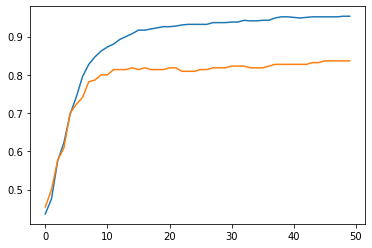

In [24]:
#modelFC.save('AbideCoronalfcmodel1After500Epochs.h5')
modelFC = keras.models.load_model("FCmodelacc80TP22.h5")

#print(history.history['accuracy'],history.history['val_accuracy'])
plt.plot(historyfc.history['accuracy'], label='accuracy')
plt.plot(historyfc.history['val_accuracy'], label = 'val_accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
#plt.legend(loc='lower right')

modelFC.evaluate(np.asarray(output2),  np.asarray(labels2))

In [25]:
prediction = modelFC.predict(np.asarray(output2))
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.asarray(labels2), np.round(prediction))


In [26]:
print(matrix)

[[154  39]
 [  5  22]]


In [66]:
# Test data
model = keras.models.load_model('AxialAbideCnn300epochsOnce.h5')
modelFC = keras.models.load_model('BestFCmodelForAxialAbide.h5')

output2=[]
labels2=[]

for batchno in range(int(len(test_images2)/32)):    
  # Iterate over the batches of the dataset.
  testbatch=test_images2[batchno*batchsize:(batchno+1)*batchsize]
  testlabel=test_labels2[(batchno*batchsize)]
  # Open a GradientTape to record the operations run
  # during the forward pass, which enables auto-differentiation.
  #testbatch=np.squeeze(testbatch,axis=3)
  #print(trainbatch.shape)
  logits = model.predict(testbatch)  # Logits for this minibatch
  logits=np.squeeze(logits,axis=1)
  output2.append(logits)
  labels2.append(testlabel)

prediction = modelFC.predict(np.asarray(output2))
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(np.asarray(labels2), np.round(prediction))

print(matrix)


[[159  35]
 [  5  22]]


0.8680794196258113


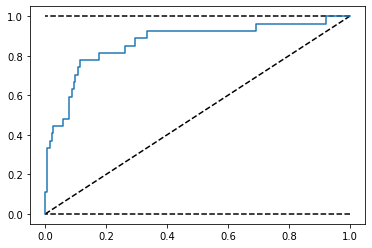

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = modelFC.predict(np.asarray(output2))
fpr, tpr, thresholds_rf = roc_curve(labels2, y_pred)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([1, 0], [0, 0], 'k--')
plt.plot([1, 0], [1, 1], 'k--')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})')
print(auc_rf)

In [69]:
print('Accuracy =',str((matrix[0,0]+matrix[1,1])/sum(sum(matrix))))
print('Sensitivity=',str((matrix[1,1])/(matrix[1,0]+matrix[1,1])))
print('Specificity=',str((matrix[0,0])/(matrix[0,1]+matrix[0,0])))
print('NPV=',str((matrix[0,0])/(matrix[0,0]+matrix[1,0])))
print('PPV=',str((matrix[1,1])/(matrix[0,1]+matrix[1,1])))
print('AUC=',str(auc_rf))

Accuracy = 0.8190045248868778
Sensitivity= 0.8148148148148148
Specificity= 0.8195876288659794
NPV= 0.9695121951219512
PPV= 0.38596491228070173
AUC= 0.8680794196258113
